# Movie Recommender System

## Business Understanding
Netflix has realized a drastic increase in the number of users on their platform. This is after a decrease in the end user interaction. It is therefore critical for them to be calculative on the business strategy they will use in order to ensure that the users are captivated and kept on screen. They have hired me to develop a recommender model that will help recommend the right movies to the users based on the items similarities. 
The objectives are as below:
* Build a recommender System that recommends movies based on item similarities.
* Handle the cold  start problem where new users have increased who we do not have past information or preference for.
* Provide insight on ways to increase user retention, watch time and subscription renewals.

## Data Understanding
The dataset used for this project was retrieved from the GroupLens MovieLens dataset from the University of Minnesota, consisting of 100,000 user ratings. The data is stored in four CSV files: links.csv, movies.csv, ratings.csv, and tags.csv. Each file has a common feature, movieId, which we will use to merge the files into a user-item-rating matrix.

**links.csv:** Contains the mapping between MovieLens movie IDs and external IDs from IMDB and TMDb.

**movies.csv:** Provides the movie titles and associated genres.

**ratings.csv:** Contains the user ratings for movies on a scale of 0.5 to 5.0.

**tags.csv:** Contains user-generated tags to describe movie content.

This data will be used to compute item-item similarities to build a recommendation system based on user ratings. Given the collaborative filtering approach, the matrix is expected to be sparse, as not all users will have rated all items. Additionally, since no user demographic information is included, handling the cold start problem will require strategies like content-based recommendations or popularity-based models for new users.

## Data Limitations

**Limited Temporal Coverage**: The dataset represents user interactions within a specific time period, which may not capture the latest shifts in movie trends or evolving audience preferences.

**Genre Imbalance**: While the dataset contains various movie genres, some genres may be underrepresented, which could limit the diversity of recommendations. Users with preferences for niche or less popular genres might not receive accurate suggestions tailored to their tastes.

**Cold-Start Problem**: The system may struggle with the cold-start problem, especially when dealing with new users or newly added movies that lack sufficient ratings or interaction data. This can hinder the system's ability to provide personalized and relevant recommendations in the absence of prior information.

**Potential Rating Bias**: User ratings can be influenced by factors like popularity bias (where users tend to rate popular movies higher) or external social dynamics. This can skew the system's predictions, leading to recommendations that do not fully reflect a user's authentic preferences. .

##### Import Relevant Libraries

In [2]:
#Import libraries 
import pandas as pd
import numpy as np
#Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#recommender system libraries
from scipy.sparse import csr_matrix
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
#to ignore any warning messages
import warnings
warnings.filterwarnings('ignore')

### 1 Loading & Inspecting the Data

In [3]:
#To view the links file under the data folder
movie_links = pd.read_csv('Data\links.csv')
#To view the first 5 elements
movie_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
#To view the movies file under the data folder
movies_df = pd.read_csv('Data\movies.csv')
movies_df.head() #To view the first 5 elements

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
#To load the ratings file under the data folder
rating_df = pd.read_csv('Data\\ratings.csv')
#To view the first 5 elements
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
#To load the tags under the data folder
tags_df = pd.read_csv('Data\\tags.csv')
#To view the first 5 elements
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


##### Merge the Movies and Ratings file on MovieId column

In [7]:
#Merge the movies to ratings table on movieid
merged_df = pd.merge(movies_df, rating_df, on='movieId')

# Display the first few rows of the merged DataFrame
merged_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


##### Inspecting the Merged DataFrame

In [8]:
#To view the shape of the merged dataFrame
merged_df.shape

(100836, 6)

In [9]:
#To view the columns
merged_df.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [10]:
#To view the information
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


In [11]:
#To view the statistical details of the dataframe
merged_df.describe()

,movieId,userId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,19435.295718,326.127564,3.501557,1.205946e+09
std,35530.987199,182.618491,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,1199.000000,177.000000,3.000000,1.019124e+09
50%,2991.000000,325.000000,3.500000,1.186087e+09
75%,8122.000000,477.000000,4.000000,1.435994e+09
max,193609.000000,610.000000,5.000000,1.537799e+09


**Findings from Data Inspection and Loading**

From above we note the max movieId:193,609, userId:610.00, min and max rating 0.5 and 5 respectively. 

We have 100,836 rows and 6 columns in our dataset.

The columns of our merged dataframe['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object'

No null values from the dataset and we have 2 types of datatypes that is float64 and int64


### 2 Data Cleaning

Now that we have merged our dataset, we will take the following steps to ensure it is clean and ready for analysis:

1. Checking for missing and address them appropriately.

2. Checking for null values  and handling duplicates columns to avoid redundancy.



#### 2.1 Checking For Missing Values

In [12]:
#Check for null values
merged_df.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

* No null values present on the dataframe

#### 2.2 Checking For Duplicates

In [13]:
#To check for duplicates.
merged_df.duplicated().sum()

0

* No duplicate found as the number of rows and columns are as per the original shape of the dataframe

### 3 Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step in understanding the dataset before applying any machine learning models or drawing conclusions. It involves visualizing and summarizing key features to uncover patterns, relationships, and potential anomalies in the data. Through EDA, we aim to gain insights on:-

* Distribution of ratings.
* Distribution of movies.
* Genre popularity in the dataset.
* UserId Distribution.

The necessary libraries were imported on the first Python code. So lets procees to visualize the data.

##### Rating Distribution Visualization

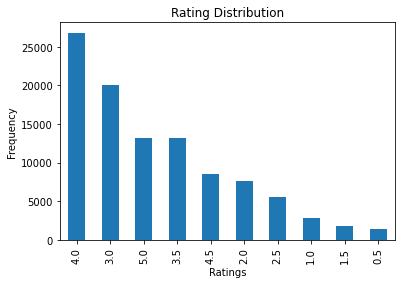

In [14]:
# Visualize distribution of ratings
merged_df['rating'].value_counts().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()

* On a scale of 0.5 to 5.0, the analysis shows that most movies received an average rating of 4.0, indicating that users generally rated the majority of films positively. This suggests a tendency for users to favorably evaluate the available content, with few movies receiving extremely low ratings of 0.5

##### Movie Distribution By Title Visualization

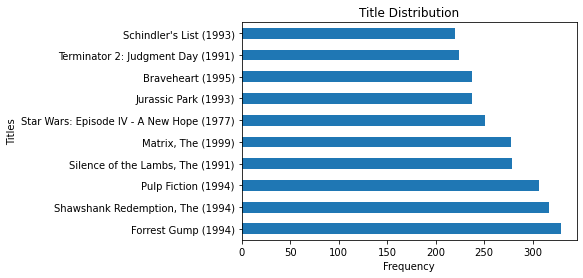

In [28]:
#To view the top 10 movies based on their titles
top_genres = merged_df['title'].value_counts().head(10)
# Visualize distribution of movie titles
top_genres.plot(kind='barh')
plt.title('Title Distribution')
plt.xlabel('Frequency')
plt.ylabel('Titles')
plt.show()

* Upon examining the data, Forrest Gump, The Shawshank Redemption, and Pulp Fiction emerge as the most frequently occurring movie titles, indicating they are popular among users. This information can be useful when making recommendations, particularly for new users who have no interaction history. These popular movies could serve as a good starting point in solving the cold start problem.

##### Movie Distribution By Genre

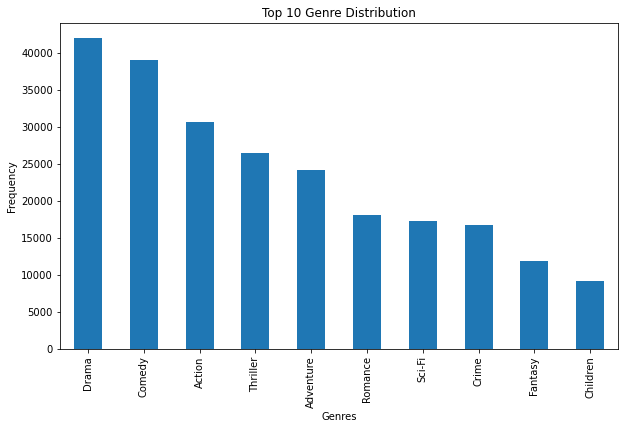

In [32]:
# Split the genres into a list
merged_df['Genres_split'] = merged_df['genres'].str.split('|')

# Explode the DataFrame so each genre is in a separate row, and count each genre
top_genres = merged_df.explode('Genres_split')['Genres_split'].value_counts().head(10)

# Plot the distribution of the top 10 genres
top_genres.plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Genre Distribution')
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.show()

* The gragh shows that the genres "Drama" and "Comedy" are the most popular among the movies in the dataset, with significantly higher counts compared to other genres.

##### UserId Distribution

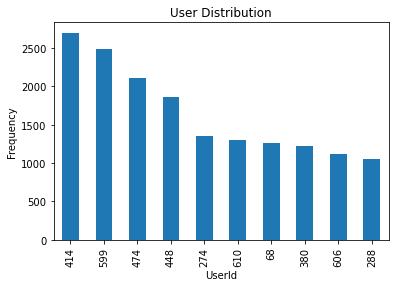

In [29]:
#To visualize the top 10 users
top_users = merged_df['userId'].value_counts().head(10)
# Visualize distribution of Userid
top_users.plot(kind='bar')
plt.title('User Distribution')
plt.xlabel('UserId')
plt.ylabel('Frequency')
plt.show()

* The most frequent userId is 414, 599 and 474 respectively when it comes to ratings and views.

### 4 Data Preprocessing

##### 4.1 User Item Matrix
We shall proceed with creating a user item matrix with the ratings as the data, users as the index and items as the columns

In [38]:
#Create user item matrix
user_item_matrix = merged_df.pivot_table(index = 'userId', columns ='title', values='rating')
user_item_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 4.2 Handle Missing Values
Since not every user will have rated every movie, the matrix will have many missing values. SVD can handle missing values implicitly by working only on the observed ratings, but for the our matrix, we want to fill in missing values with zeros

In [39]:
matrix_df = user_item_matrix.fillna(0)
matrix_df.head()


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### 4.3 Normalizing Data
For better performance of SVD, we will proceed and normalize or mean-center the ratings by subtracting the user or movie average


In [41]:
user_ratings_mean = matrix_df.mean(axis=1)
user_item_matrix_normalized = matrix_df.sub(user_ratings_mean, axis=0)
user_item_matrix_normalized .head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.104229,-0.104229,-0.104229,-0.104229,-0.104229,-0.104229,-0.104229,-0.104229,-0.104229,-0.104229,...,-0.104229,-0.104229,-0.104229,-0.104229,-0.104229,-0.104229,-0.104229,-0.104229,3.895771,-0.104229
2,-0.011781,-0.011781,-0.011781,-0.011781,-0.011781,-0.011781,-0.011781,-0.011781,-0.011781,-0.011781,...,-0.011781,-0.011781,-0.011781,-0.011781,-0.011781,-0.011781,-0.011781,-0.011781,-0.011781,-0.011781
3,-0.009775,-0.009775,-0.009775,-0.009775,-0.009775,-0.009775,-0.009775,-0.009775,-0.009775,-0.009775,...,-0.009775,-0.009775,-0.009775,-0.009775,-0.009775,-0.009775,-0.009775,-0.009775,-0.009775,-0.009775
4,-0.079020,-0.079020,-0.079020,-0.079020,-0.079020,-0.079020,-0.079020,-0.079020,-0.079020,-0.079020,...,-0.079020,-0.079020,-0.079020,-0.079020,-0.079020,-0.079020,-0.079020,-0.079020,-0.079020,-0.079020
5,-0.016463,-0.016463,-0.016463,-0.016463,-0.016463,-0.016463,-0.016463,-0.016463,-0.016463,-0.016463,...,-0.016463,-0.016463,-0.016463,-0.016463,-0.016463,-0.016463,-0.016463,-0.016463,-0.016463,-0.016463


### 5 Modelling

##### Collaborative Filtering

In [19]:
# Create a user-item matrix with ratings 
#Use the compressed sparse row (CSR) format. This is a memory-efficient 
user_item_matrix = csr_matrix((merged_df['rating'], (merged_df['userId'], merged_df['movieId'])))

* Here we have 610 users 

In [20]:
# Drop unnecessary columns and put the required columns movie, user and ratings into the new_df Dataframe
new_df = merged_df.drop(['timestamp', 'title', 'genres'], axis=1)
reader = Reader()
data = Dataset.load_from_df(new_df,reader)
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  9724 

Number of items:  610


From the above number of users and items we note several concerns:
* The number of users significantly exceeds the number of items. If most users have rated only a small subset of the available items, the data becomes sparse. Sparse data can lead to unreliable recommendations since the model may not have enough information to accurately predict a user’s preferences.
* New users or items may not have enough interactions (ratings) to generate meaningful recommendations. 

